 ## Project "Shelter Animal Outcomes" - phase II

This project was written for a Kaggle competition:
https://www.kaggle.com/c/shelter-animal-outcomes/test
Our goal was to predict the outcome of the animal as they leave the Animal Center.. We use the date comes from Austin Animal Center (October 1st, 2013 - March, 2016). Outcomes represent the status of animals as they leave the Animal Center. 

In the Phase I got the result 0.92197 using the VotingClassifier(Logistic Regression, CalibratedClassifierCV, and Random Forest) withefeatures = ['Name','AnimalType', 'AgeuponOutcome', 'Breed','SexuponOutcome_Intact Female', 'SexuponOutcome_Intact Male','SexuponOutcome_Neutered Male', 'SexuponOutcome_Spayed Female', 'SexuponOutcome_Unknown']

Now I am going to try using "DateTime" since it is the time of outcome and I think, the adoption could be most likely on Weekends. Also, I am going to try to get some useful information from "Breed". 

Let's look at the test again:

In [1]:
import pandas
data = pandas.read_csv("train.csv")
data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [2]:
data.shape

(26729, 10)

In [3]:
data = data[data["OutcomeType"] != "NaN"]
data['AnimalType'] =data['AnimalType'].fillna("Dog")
data['Breed'] =data['Breed'].fillna("Mix")
data['SexuponOutcome'] =data['SexuponOutcome'].fillna("Neutered Male")

We do not need AnimalId and OutcomeSubtype sinse we do not have them in the test set.

In [4]:
del data["AnimalID"]
del data["OutcomeSubtype"]

In [5]:
data['Name'] =data['Name'].fillna(0)
data.loc[data['Name'] != 0, "Name"] = 1
data.loc[data["AnimalType"]== "Dog", "AnimalType"] = 1
data.loc[data["AnimalType"]!= 1, "AnimalType"] = 0

Let's create "Day_of_week" and "Hour" columns:

In [6]:
data['Hour'] = data.DateTime.map( lambda x: pandas.to_datetime(x).hour )

In [7]:
data['Day_of_Week'] = data.DateTime.map( lambda x: pandas.to_datetime(x).dayofweek )

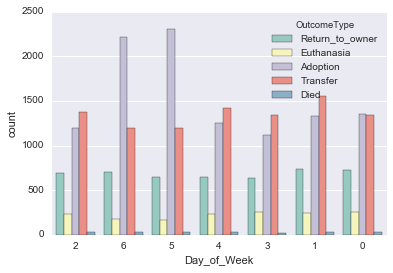

In [65]:
import seaborn as sns
%matplotlib inline

sns.countplot(data=data, x='Day_of_Week',hue="OutcomeType", palette = "Set3")

"5" and "6" means "Suturday" and "Sunday". The animals are more likely adopted at Weekends! Thus, I am replacing 5 and 6 by 1, and other numbers by 0

In [8]:
data.loc[data["Day_of_Week"]== 5, "Day_of_Week"] = 10
data.loc[data["Day_of_Week"]== 6, "Day_of_Week"] = 10
data.loc[data["Day_of_Week"]!= 10, "Day_of_Week"] = 0
data.loc[data["Day_of_Week"]== 10, "Day_of_Week"] = 1
data.head()

,Name,DateTime,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Hour,Day_of_Week
0,1,2014-02-12 18:22:00,Return_to_owner,1,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,18,0
1,1,2013-10-13 12:44:00,Euthanasia,0,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,12,1
2,1,2015-01-31 12:28:00,Adoption,1,Neutered Male,2 years,Pit Bull Mix,Blue/White,12,1
3,0,2014-07-11 19:09:00,Transfer,0,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,19,0
4,0,2013-11-15 12:52:00,Transfer,1,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,12,0


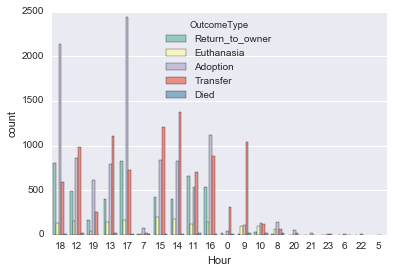

In [67]:
sns.countplot(data=data, x='Hour',hue="OutcomeType", palette = "Set3")

It is interesting! The animal are adopted more likely at 16-19 and 7-8; transfered at 0, 9, 12-15. Thus, I am going to create features: 16and19, 17and18, 7and8, 9, 0, 12and13, 14and15, other_time.

In [9]:
def day(x):
    if x == 16 or x == 19:
        x = "16and19"
    elif x == 17 or x == 18:
        x = "17and18"
    elif x == 7 or x == 8:
        x = "7and8"
    elif x == 12 or x == 13:
        x = "12and13"
    elif x == 14 or x == 15:
        x = "14and15"
    elif x == 9:
        x = "9"
    elif x == 0:
        x = "0"
    else:
        x = "other_time"
    return x
       
data['Hour'] = data.Hour.apply(day)
data.head()

,Name,DateTime,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Hour,Day_of_Week
0,1,2014-02-12 18:22:00,Return_to_owner,1,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,17and18,0
1,1,2013-10-13 12:44:00,Euthanasia,0,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,12and13,1
2,1,2015-01-31 12:28:00,Adoption,1,Neutered Male,2 years,Pit Bull Mix,Blue/White,12and13,1
3,0,2014-07-11 19:09:00,Transfer,0,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,16and19,0
4,0,2013-11-15 12:52:00,Transfer,1,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,12and13,0


In [10]:
def age_as_float(x):
    x = str(x)
    x_list = x.split(" ")
    if len(x_list)==2:
        if x_list[1] =='year': return 1.0
        elif x_list[1] =='years': return float(x_list[0])
        elif x_list[1] =='month': return float(x_list[0])/12
        elif x_list[1] =='months': return float(x_list[0])/12
        elif x_list[1] =='week': return float(x_list[0])
        elif x_list[1] =='weeks': return float(x_list[0])/54
        elif x_list[1] =='days': return float(x_list[0])/365
        else: return 0
    else:return 0

data['AgeuponOutcome'] = data.AgeuponOutcome.apply(age_as_float)
#now we have 0 age for the animals with undefined age. Let's replace 0 by mean age:
data.loc[data['AgeuponOutcome']== 0, "AgeuponOutcome"] = data['AgeuponOutcome'].median()

In [11]:
#I used tutorial from https://www.dataquest.io/learn
def create_dummies(var):
    var_unique = var.unique()
    var_unique.sort()
    dummy = pandas.DataFrame()
    for val in var_unique:
    #for val in var_unique[:-1]:
        # which columns are equal to our unique value
        d = var == val
        # make a new column with a dummy variable
        dummy[var.name + "_" + str(val)] = d.astype(int)
    return(dummy)

sex_dummies = create_dummies(data["SexuponOutcome"])
data = pandas.concat([data, sex_dummies], axis=1)
del data["SexuponOutcome"]

hour = create_dummies(data["Hour"])
data = pandas.concat([data, hour], axis=1)
del data["Hour"]

data.head()

,Name,DateTime,OutcomeType,AnimalType,AgeuponOutcome,Breed,Color,Day_of_Week,SexuponOutcome_Intact Female,SexuponOutcome_Intact Male,...,SexuponOutcome_Spayed Female,SexuponOutcome_Unknown,Hour_0,Hour_12and13,Hour_14and15,Hour_16and19,Hour_17and18,Hour_7and8,Hour_9,Hour_other_time
0,1,2014-02-12 18:22:00,Return_to_owner,1,1.000000,Shetland Sheepdog Mix,Brown/White,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,2013-10-13 12:44:00,Euthanasia,0,1.000000,Domestic Shorthair Mix,Cream Tabby,1,0,0,...,1,0,0,1,0,0,0,0,0,0
2,1,2015-01-31 12:28:00,Adoption,1,2.000000,Pit Bull Mix,Blue/White,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,2014-07-11 19:09:00,Transfer,0,0.055556,Domestic Shorthair Mix,Blue Cream,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,0,2013-11-15 12:52:00,Transfer,1,2.000000,Lhasa Apso/Miniature Poodle,Tan,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [12]:
items_counts = data['Breed'].value_counts()

I am going to work with breeds with count > 150. Also, I am going to add "Boxer" and "Pit Bull" to my list since this dogs can be agressive. 

In [13]:
to_my_breads = data['Breed'].value_counts() > 150

In [14]:
items_counts[to_my_breads]

Domestic Shorthair Mix       8810
Pit Bull Mix                 1906
Chihuahua Shorthair Mix      1766
Labrador Retriever Mix       1363
Domestic Medium Hair Mix      839
German Shepherd Mix           575
Domestic Longhair Mix         520
Siamese Mix                   389
Australian Cattle Dog Mix     367
Dachshund Mix                 318
Boxer Mix                     245
Miniature Poodle Mix          233
Border Collie Mix             229
Australian Shepherd Mix       163
Rat Terrier Mix               157
Catahoula Mix                 157
Name: Breed, dtype: int64

In [15]:
my_breeds = ["Domestic Shorthair", "Chihuahua Shorthair", "Labrador Retriever", 
             "Domestic Medium Hair", "German Shepherd", "Domestic Longhair", "Siamese", "Australian Cattle Dog", 
             "Dachshund", "Miniature Poodle", "Border Collie","Australian Shepherd", "Rat Terrier", "Catahoula", 
              "Husky", "Rottweiler", "Bulldog", "Pit Bull", "Boxer"]

In [16]:
import re
def breeds(x):
    x = str(x)
    breed = "other"
    for b in my_breeds:
        if re.search(b, x):
            breed = b
    return breed
data['My_Breeds'] = data.Breed.apply(breeds) 
data.head()

,Name,DateTime,OutcomeType,AnimalType,AgeuponOutcome,Breed,Color,Day_of_Week,SexuponOutcome_Intact Female,SexuponOutcome_Intact Male,...,SexuponOutcome_Unknown,Hour_0,Hour_12and13,Hour_14and15,Hour_16and19,Hour_17and18,Hour_7and8,Hour_9,Hour_other_time,My_Breeds
0,1,2014-02-12 18:22:00,Return_to_owner,1,1.000000,Shetland Sheepdog Mix,Brown/White,0,0,0,...,0,0,0,0,0,1,0,0,0,other
1,1,2013-10-13 12:44:00,Euthanasia,0,1.000000,Domestic Shorthair Mix,Cream Tabby,1,0,0,...,0,0,1,0,0,0,0,0,0,Domestic Shorthair
2,1,2015-01-31 12:28:00,Adoption,1,2.000000,Pit Bull Mix,Blue/White,1,0,0,...,0,0,1,0,0,0,0,0,0,Pit Bull
3,0,2014-07-11 19:09:00,Transfer,0,0.055556,Domestic Shorthair Mix,Blue Cream,0,0,1,...,0,0,0,0,1,0,0,0,0,Domestic Shorthair
4,0,2013-11-15 12:52:00,Transfer,1,2.000000,Lhasa Apso/Miniature Poodle,Tan,0,0,0,...,0,0,1,0,0,0,0,0,0,Miniature Poodle


In [17]:
len(data["My_Breeds"].unique())

20

In [18]:
breed_dummies = create_dummies(data["My_Breeds"])
data = pandas.concat([data, breed_dummies], axis=1)
del data["My_Breeds"]
del data["Breed"]

In [19]:
features = data.columns.tolist() 
print(features)

['Name', 'DateTime', 'OutcomeType', 'AnimalType', 'AgeuponOutcome', 'Color', 'Day_of_Week', 'SexuponOutcome_Intact Female', 'SexuponOutcome_Intact Male', 'SexuponOutcome_Neutered Male', 'SexuponOutcome_Spayed Female', 'SexuponOutcome_Unknown', 'Hour_0', 'Hour_12and13', 'Hour_14and15', 'Hour_16and19', 'Hour_17and18', 'Hour_7and8', 'Hour_9', 'Hour_other_time', 'My_Breeds_Australian Cattle Dog', 'My_Breeds_Australian Shepherd', 'My_Breeds_Border Collie', 'My_Breeds_Boxer', 'My_Breeds_Bulldog', 'My_Breeds_Catahoula', 'My_Breeds_Chihuahua Shorthair', 'My_Breeds_Dachshund', 'My_Breeds_Domestic Longhair', 'My_Breeds_Domestic Medium Hair', 'My_Breeds_Domestic Shorthair', 'My_Breeds_German Shepherd', 'My_Breeds_Husky', 'My_Breeds_Labrador Retriever', 'My_Breeds_Miniature Poodle', 'My_Breeds_Pit Bull', 'My_Breeds_Rat Terrier', 'My_Breeds_Rottweiler', 'My_Breeds_Siamese', 'My_Breeds_other']


In [20]:
features.remove("DateTime")
features.remove("OutcomeType")
features.remove("Color")

In [21]:
import numpy as np
# shuffle data
shuffled_rows = np.random.permutation(data.index)

# Select 70% of the dataset to be training data
highest_train_row = int(data.shape[0] * .70)
train = data.loc[shuffled_rows[:highest_train_row], :]

# Select 30% of the dataset to be test data
my_test = data.loc[shuffled_rows[highest_train_row:], :]

train.head()

,Name,DateTime,OutcomeType,AnimalType,AgeuponOutcome,Color,Day_of_Week,SexuponOutcome_Intact Female,SexuponOutcome_Intact Male,SexuponOutcome_Neutered Male,...,My_Breeds_Domestic Shorthair,My_Breeds_German Shepherd,My_Breeds_Husky,My_Breeds_Labrador Retriever,My_Breeds_Miniature Poodle,My_Breeds_Pit Bull,My_Breeds_Rat Terrier,My_Breeds_Rottweiler,My_Breeds_Siamese,My_Breeds_other
11708,1,2013-11-09 14:53:00,Transfer,1,0.333333,Brown/Black,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8184,1,2015-06-29 17:45:00,Adoption,0,0.166667,Brown Tabby,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19876,1,2014-03-16 15:29:00,Adoption,1,0.416667,White/Black,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
13784,0,2014-12-27 12:12:00,Transfer,1,0.005479,Chocolate/White,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
16277,0,2014-03-17 13:34:00,Return_to_owner,1,1.000000,White/Brown Brindle,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [28]:
from sklearn import linear_model

alg = linear_model.LogisticRegression(random_state=1)
alg.fit(train[features], train["OutcomeType"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [29]:
probs = alg.predict_proba(my_test[features])

In [30]:
from sklearn import metrics
score = metrics.log_loss(my_test["OutcomeType"], probs)
print(score)

0.864507646155


In [114]:
from sklearn.ensemble import RandomForestClassifier
alg2 = RandomForestClassifier()
alg2.fit(train[features], train["OutcomeType"])
probs = alg2.predict_proba(my_test[features])
score = metrics.log_loss(my_test["OutcomeType"], probs)
print(score)

3.7471760858


In [115]:
from sklearn.calibration import CalibratedClassifierCV
alg7 = CalibratedClassifierCV()
alg7.fit(train[features], train["OutcomeType"])
probs = alg7.predict_proba(my_test[features])
score = metrics.log_loss(my_test["OutcomeType"], probs)
print(score)

0.866012083808


In [116]:
from sklearn.tree import DecisionTreeClassifier
alg6 = DecisionTreeClassifier()
alg6.fit(train[features], train["OutcomeType"])
probs = alg6.predict_proba(my_test[features])
score = metrics.log_loss(my_test["OutcomeType"], probs)
print(score)

7.82956960519


In [117]:
from sklearn.ensemble import AdaBoostClassifier
alg4 =AdaBoostClassifier()
alg4.fit(train[features], train["OutcomeType"])
probs = alg4.predict_proba(my_test[features])
score = metrics.log_loss(my_test["OutcomeType"], probs)
print(score)

1.54229076685


In [118]:
from sklearn import svm
alg8 = svm.SVC(probability=True)
alg8.fit(train[features], train["OutcomeType"])
probs = alg8.predict_proba(my_test[features])
score = metrics.log_loss(my_test["OutcomeType"], probs)
print(score)

0.857695846071


In [64]:
from sklearn.ensemble import VotingClassifier
eclf = VotingClassifier(estimators=[('lr', alg), ('svm', alg8)], voting='soft')
eclf.fit(train[features], train["OutcomeType"])
probs = eclf.predict_proba(my_test[features])
score = metrics.log_loss(my_test["OutcomeType"], probs)
print(score)

0.841768000562


In [65]:
eclf1 = VotingClassifier(estimators=[('lr', alg), ('calC', alg7)], voting='soft')
eclf1.fit(train[features], train["OutcomeType"])
probs = eclf1.predict_proba(my_test[features])
score = metrics.log_loss(my_test["OutcomeType"], probs)
print(score)

0.857304611749


In [31]:
from sklearn.ensemble import GradientBoostingClassifier
alg9 = GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3)
alg9.fit(train[features], train["OutcomeType"])
probs = alg9.predict_proba(my_test[features])
score = metrics.log_loss(my_test["OutcomeType"], probs)
print(score)

0.853139717405


In [81]:
eclf2 = VotingClassifier(estimators=[('lr', alg), ('svm', alg8), ("GBC", alg9)], voting='soft')
eclf2.fit(train[features], train["OutcomeType"])
probs = eclf2.predict_proba(my_test[features])
score = metrics.log_loss(my_test["OutcomeType"], probs)
print(score)

0.833464705813


Not bad. Now let's create a prediction for text.csv and submit it for Kagle competition. 

In [82]:
eclf3 = VotingClassifier(estimators=[('lr', alg), ("GBC", alg9)], voting='soft')
eclf3.fit(train[features], train["OutcomeType"])
probs = eclf3.predict_proba(my_test[features])
score = metrics.log_loss(my_test["OutcomeType"], probs)
print(score)

0.83638876405


In [83]:
eclf4 = VotingClassifier(estimators=[('svm', alg8), ("GBC", alg9)], voting='soft')
eclf4.fit(train[features], train["OutcomeType"])
probs = eclf4.predict_proba(my_test[features])
score = metrics.log_loss(my_test["OutcomeType"], probs)
print(score)

0.835701058263


In [34]:
test = pandas.read_csv("test.csv")
test['AnimalType'] =test['AnimalType'].fillna("Dog")
test['Breed'] =test['Breed'].fillna("Mix")
test['SexuponOutcome'] =test['SexuponOutcome'].fillna("Neutered Male")
test['Name'] =test['Name'].fillna(0)
test.loc[test['Name'] != 0, "Name"] = 1
test.loc[test["AnimalType"]== "Dog", "AnimalType"] = 1
test.loc[test["AnimalType"]!= 1, "AnimalType"] = 0
test['Hour'] = test.DateTime.map( lambda x: pandas.to_datetime(x).hour )
test['Day_of_Week'] = test.DateTime.map( lambda x: pandas.to_datetime(x).dayofweek )
test.loc[test["Day_of_Week"]== 5, "Day_of_Week"] = 10
test.loc[test["Day_of_Week"]== 6, "Day_of_Week"] = 10
test.loc[test["Day_of_Week"]!= 10, "Day_of_Week"] = 0
test.loc[test["Day_of_Week"]== 10, "Day_of_Week"] = 1
test['Hour'] = test.Hour.apply(day)
test['AgeuponOutcome'] = test.AgeuponOutcome.apply(age_as_float)
test.loc[test['AgeuponOutcome']== 0, "AgeuponOutcome"] = test['AgeuponOutcome'].median()
sex_dummies = create_dummies(test["SexuponOutcome"])
test = pandas.concat([test, sex_dummies], axis=1)
del test["SexuponOutcome"]
hour = create_dummies(test["Hour"])
test = pandas.concat([test, hour], axis=1)
del test["Hour"]
test['My_Breeds'] = test.Breed.apply(breeds)
breed_dummies = create_dummies(test["My_Breeds"])
test = pandas.concat([test, breed_dummies], axis=1)
del test["My_Breeds"]
del test["Breed"]

In [35]:
result = pandas.DataFrame(eclf5.predict_proba(test[features]), index=test.index, columns=alg.classes_)
result.head()

,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,0.066582,0.012452,0.054471,0.185165,0.681330
1,0.636766,0.006342,0.024703,0.274385,0.057805
2,0.470630,0.011337,0.029371,0.085998,0.402664
3,0.201900,0.024200,0.057502,0.326583,0.389815
4,0.550867,0.008047,0.023805,0.323337,0.093944


In [36]:
sample_submission = pandas.read_csv("sample_submission.csv")
sample_submission.head()

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,1,0,0,0,0
1,2,1,0,0,0,0
2,3,1,0,0,0,0
3,4,1,0,0,0,0
4,5,1,0,0,0,0


In [37]:
mid = sample_submission['ID']
result.insert(0, 'ID', mid)
result.head()

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,0.066582,0.012452,0.054471,0.185165,0.681330
1,2,0.636766,0.006342,0.024703,0.274385,0.057805
2,3,0.470630,0.011337,0.029371,0.085998,0.402664
3,4,0.201900,0.024200,0.057502,0.326583,0.389815
4,5,0.550867,0.008047,0.023805,0.323337,0.093944


In [38]:
result.to_csv("etcareva12.csv", index=False)

Using VotingClassifier with Logistic Regression, SVM, and GradientBoostingClassifier I got 0.83097 score after submission and moved up by 183 positions on the leaderboard. The scores of other participants are between 0.45 and 29.00. 

Now I am going to try SVM with diferent parametrs.

In [25]:
from sklearn import svm, grid_search
parameters = {'kernel':('linear', 'rbf'), 'C':[0.001, 0.01, 0.1, 1, 10]}
svr = svm.SVC(probability=True)
clf = grid_search.GridSearchCV(svr, parameters)
clf.fit(train[features], train["OutcomeType"])

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ('linear', 'rbf')},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [26]:
probs = clf.predict_proba(my_test[features])
score = metrics.log_loss(my_test["OutcomeType"], probs)
print(score)

0.849973275154


We had 0.857695846071 from svm before CridSearch.

In [32]:
from sklearn.ensemble import VotingClassifier
eclf5 = VotingClassifier(estimators=[('lr', alg), ('svm_gs', clf), ("GBC", alg9)], voting='soft')
eclf5.fit(train[features], train["OutcomeType"])
probs = eclf5.predict_proba(my_test[features])
score = metrics.log_loss(my_test["OutcomeType"], probs)
print(score)

0.834360039446


I got 0.82418 after submission and moved 23 position up on the leaderboard.

## Conclusion

I used multi class logistic regression for this project and got log_loss 0.92871. I also did some useful observations.
1. Neutered Male and Spayed Female have a great chance to be adopted, but it is very hard to find new family for Intact Male and Intact Female!
2. It is important for an animal to have an ID tag (I think that the shelter staff learned the names from the tags. The animals with unknown names have almost no chance to return to owners and have less chance to be adopted.